<a href="https://colab.research.google.com/github/YuxuanLiu0622/ECE50024-Project-Team15/blob/main/checkpoint3_reweight_upload.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Checkpoint 3: Reimplementation of Learning to Reweight Examples for Robust Deep Learning on Toy Problems (FashionMNIST) Part 2: CNN with reweighting

**Team15: Hyun Soo Park, Andres Martinez, Heesoo Kim, Mingyu Kim, Yuxuan Liu**

In [ ]:
!pip install tqdm
!pip install higher
import time
from typing import List, Dict
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from copy import deepcopy
from tqdm import tqdm
import IPython
import higher

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def set_seed(seed: int = 0) -> None:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
set_seed(0)

For a fair comparison, we keep the structure of the baseline CNN, where there are four layers with increasing channels, followed by ReLU and max pooling for binary classfication.

In [ ]:
class CNN(nn.Module):

  def __init__(self):
    super(CNN, self).__init__()

    self.conv = nn.Conv2d(1, 8, kernel_size=3)
    self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
    self.conv3 = nn.Conv2d(16,32,kernel_size=3)
    self.conv4 = nn.Conv2d(32,32,kernel_size=3)
    self.fc = nn.Linear(512, 1)

  def forward(self, x):
    x = self.conv(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.relu(F.max_pool2d(x,2))
    x = self.conv3(x)
    x = F.relu(x)
    x = self.conv4(x)
    x = F.relu(x)
    x = F.relu(F.max_pool2d(x,2))
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.1307,),(0.3081,))])

We target the classification of "sneakers" (class 7) and "ankle boots" (class 9) in FashionMNist dataset.

In [ ]:
train_fmnist = torchvision.datasets.FashionMNIST(root="data", train=True, download=True,transform=transform)
test_fmnist = torchvision.datasets.FashionMNIST(root="data", train=False, download=True,transform=transform)
val_fmnist = torchvision.datasets.FashionMNIST(root="data", train=False, download=True,transform=transform)

100%|██████████| 26421880/26421880 [00:02<00:00, 11122921.89it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 200402.25it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3723986.02it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4951221.51it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
def split_dataset(class1: int, class2: int, imbalance_ratio: float, n_samples: int, train_dataset: torchvision.datasets) -> torch.utils.data.Dataset:
    new_data = train_dataset
    n_class1 = int(imbalance_ratio*n_samples)
    n_class2 = n_samples - n_class1
    class1_indices = (train_dataset.targets == class1).nonzero().squeeze()
    class2_indices = (train_dataset.targets == class2).nonzero().squeeze()

    # Randomly sample indices for each class based on the desired number of samples
    selected_class1_indices = class1_indices[torch.randperm(class1_indices.size(0))[:n_class1]]
    selected_class2_indices = class2_indices[torch.randperm(class2_indices.size(0))[:n_class2]]

    new_data.data = torch.cat((train_dataset.data[selected_class1_indices], train_dataset.data[selected_class2_indices]))

    # Update the targets based on the new number of samples
    new_data.targets = torch.cat((torch.zeros(selected_class1_indices.size()), torch.ones(selected_class2_indices.size())))
    return new_data

The training set is given an imbalanced proportion of 99.5%. The validation and testing set is equally distributed.

In [ ]:
train_set = split_dataset(7,9,0.9,8000,train_fmnist)
test_set = split_dataset(7,9,0.5,1000,test_fmnist)
val_set = split_dataset(7,9,0.5,50,val_fmnist)

In [ ]:
train_loader = DataLoader(dataset=train_set, batch_size = hyperparameters['batch_size'], shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=hyperparameters['batch_size'], shuffle=False)
val_loader = DataLoader(dataset=val_set, batch_size=hyperparameters['batch_size'], shuffle=False)

## Apply reweighting method to CNN

In [ ]:
# set the hyperparameter
hyperparameters = {
    'lr' : 1e-3,
    'momentum' : 0.9,
    'batch_size' : 128,
    'epoch' : 5000,
}

In [ ]:
model = CNN().to(device)
opt = optim.SGD(model.parameters(), lr=hyperparameters['lr'])
loss_fn = nn.BCEWithLogitsLoss().to(device)

In [ ]:
overall_accuracy = []
for i in tqdm(range(1, hyperparameters['epoch']+1)):
  model.train()
  train_loss, train_acc = 0, 0
  images, labels = next(iter(train_loader))

  images_tr = images.to(device)
  labels_tr = labels.to(device)

  opt.zero_grad()

  # the adjustment of weight is based on the validation set
  with higher.innerloop_ctx(model, opt) as (meta_model, meta_opt):
    meta_train_outputs = meta_model(images_tr).squeeze()
    loss_fn.reduction = 'none'
    meta_train_loss = loss_fn(meta_train_outputs, labels.float())

    # epsilon is initialized to be 0 (in fact any number is okay)
    eps = torch.full(meta_train_loss.size(), 0.5,requires_grad=True).to(device)

    # construct the computational graph, now the loss is a function of both model parameter and weight
    meta_train_loss = torch.sum(eps * meta_train_loss)
    meta_opt.step(meta_train_loss)

    #give the inference on the validation set, and return the loss
    images_meta, labels_meta = next(iter(val_loader))
    y_g_hat = meta_model(images_meta).squeeze()

    loss_fn.reduction = 'mean'
    meta_val_loss = loss_fn(y_g_hat, labels_meta.float())

    # take the gradient wrt epsilon
    eps_grads = torch.autograd.grad(meta_val_loss, eps)[0].detach()

  # limit the weight >=0 and normalize it
  w_tilde = torch.clamp(-eps_grads, min=0)
  l1_norm = torch.sum(w_tilde)
  if l1_norm != 0:
      w = w_tilde / l1_norm
  else:
      w = w_tilde

  # train the data based on the weighted loss
  y_f_hat = model(images).squeeze()
  loss_f_hat = torch.sum(w * loss_fn(y_f_hat, labels.float()))
  loss_f_hat.backward()
  opt.step()

  train_loss += loss_f_hat.item()
  pred_labels = (F.sigmoid(y_f_hat) > 0.5).int()
  train_acc += torch.sum(torch.eq(pred_labels, labels)).item()

  # record the loss and accuracy every 100 iterations
  if i % 100 == 0 and i != 0:
      model.eval()
      test_acc = []
      # use the testing set
      for i, (images_test, labels_test) in enumerate(test_loader):
          images_test = images_test.to(device)
          labels_test = labels_test.to(device)

          y_hat = model(images_test).to(device)
          # since this is a binary classification, the decision is made based on the threshold 0.5
          prediction = (F.sigmoid(y_hat) > 0.5).int()
          test_acc.append((torch.flatten(prediction).int() == labels_test.int()).int())

      acc = torch.mean(torch.cat(test_acc,dim=0).float())
      overall_accuracy.append(np.array(acc))
      print(acc)

  2%|▏         | 100/5000 [00:29<37:33,  2.17it/s]

tensor(0.5000)


  4%|▍         | 200/5000 [00:57<31:54,  2.51it/s]

tensor(0.5000)


  6%|▌         | 300/5000 [01:26<29:59,  2.61it/s]

tensor(0.5000)


  8%|▊         | 400/5000 [01:57<43:49,  1.75it/s]

tensor(0.5000)


 10%|█         | 500/5000 [02:25<29:19,  2.56it/s]

tensor(0.5000)


 12%|█▏        | 600/5000 [02:53<27:50,  2.63it/s]

tensor(0.5000)


 14%|█▍        | 700/5000 [03:21<26:44,  2.68it/s]

tensor(0.5000)


 16%|█▌        | 800/5000 [03:48<34:45,  2.01it/s]

tensor(0.5000)


 18%|█▊        | 900/5000 [04:16<26:50,  2.55it/s]

tensor(0.5000)


 20%|██        | 1000/5000 [04:43<25:37,  2.60it/s]

tensor(0.5000)


 22%|██▏       | 1100/5000 [05:11<24:23,  2.66it/s]

tensor(0.5000)


 24%|██▍       | 1200/5000 [05:39<30:59,  2.04it/s]

tensor(0.5000)


 26%|██▌       | 1300/5000 [06:07<23:58,  2.57it/s]

tensor(0.5000)


 28%|██▊       | 1400/5000 [06:34<22:26,  2.67it/s]

tensor(0.5000)


 30%|███       | 1500/5000 [07:01<21:52,  2.67it/s]

tensor(0.5000)


 32%|███▏      | 1600/5000 [07:29<21:36,  2.62it/s]

tensor(0.5000)


 34%|███▍      | 1700/5000 [07:58<29:44,  1.85it/s]

tensor(0.5000)


 36%|███▌      | 1800/5000 [08:25<20:25,  2.61it/s]

tensor(0.5000)


 38%|███▊      | 1900/5000 [08:52<19:31,  2.65it/s]

tensor(0.5000)


 40%|████      | 2000/5000 [09:19<18:40,  2.68it/s]

tensor(0.5000)


 42%|████▏     | 2100/5000 [09:46<19:29,  2.48it/s]

tensor(0.5000)


 44%|████▍     | 2200/5000 [10:14<18:58,  2.46it/s]

tensor(0.5000)


 46%|████▌     | 2300/5000 [10:42<17:06,  2.63it/s]

tensor(0.5000)


 48%|████▊     | 2400/5000 [11:10<16:00,  2.71it/s]

tensor(0.5000)


 50%|█████     | 2500/5000 [11:37<16:22,  2.55it/s]

tensor(0.5010)


 52%|█████▏    | 2600/5000 [12:05<18:52,  2.12it/s]

tensor(0.5190)


 54%|█████▍    | 2700/5000 [12:32<14:26,  2.66it/s]

tensor(0.5870)


 56%|█████▌    | 2800/5000 [12:59<13:53,  2.64it/s]

tensor(0.7210)


 58%|█████▊    | 2900/5000 [13:27<13:17,  2.63it/s]

tensor(0.7870)


 60%|██████    | 3000/5000 [13:55<17:13,  1.94it/s]

tensor(0.8270)


 62%|██████▏   | 3100/5000 [14:22<12:09,  2.60it/s]

tensor(0.8520)


 64%|██████▍   | 3200/5000 [14:49<11:23,  2.63it/s]

tensor(0.8610)


 66%|██████▌   | 3300/5000 [15:16<10:44,  2.64it/s]

tensor(0.8670)


 68%|██████▊   | 3400/5000 [15:45<12:02,  2.21it/s]

tensor(0.8680)


 70%|███████   | 3500/5000 [16:13<10:14,  2.44it/s]

tensor(0.8660)


 72%|███████▏  | 3600/5000 [16:40<08:47,  2.65it/s]

tensor(0.8690)


 74%|███████▍  | 3700/5000 [17:07<08:08,  2.66it/s]

tensor(0.8750)


 76%|███████▌  | 3800/5000 [17:35<08:21,  2.39it/s]

tensor(0.8750)


 78%|███████▊  | 3900/5000 [18:04<07:23,  2.48it/s]

tensor(0.8790)


 80%|████████  | 4000/5000 [18:32<06:13,  2.68it/s]

tensor(0.8750)


 82%|████████▏ | 4100/5000 [18:59<05:37,  2.66it/s]

tensor(0.8800)


 84%|████████▍ | 4200/5000 [19:27<05:40,  2.35it/s]

tensor(0.8800)


 86%|████████▌ | 4300/5000 [19:54<04:48,  2.43it/s]

tensor(0.8820)


 88%|████████▊ | 4400/5000 [20:22<03:46,  2.65it/s]

tensor(0.8720)


 90%|█████████ | 4500/5000 [20:50<03:07,  2.67it/s]

tensor(0.8720)


 92%|█████████▏| 4600/5000 [21:17<02:31,  2.64it/s]

tensor(0.8780)


 94%|█████████▍| 4700/5000 [21:45<02:27,  2.03it/s]

tensor(0.8790)


 96%|█████████▌| 4800/5000 [22:13<01:15,  2.66it/s]

tensor(0.8760)


 98%|█████████▊| 4900/5000 [22:40<00:37,  2.63it/s]

tensor(0.8800)


100%|██████████| 5000/5000 [23:07<00:00,  3.60it/s]

tensor(0.8810)


The following 4 sections are the same for plotting, you can just check one

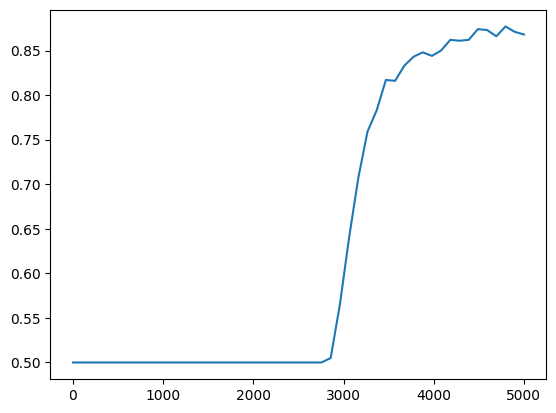

In [ ]:
itr = np.linspace(1,5000,50)
overall_accuracy = np.array(overall_accuracy)
accuracy_0 = overall_accuracy
plt.plot(itr,accuracy_0)

(37,)


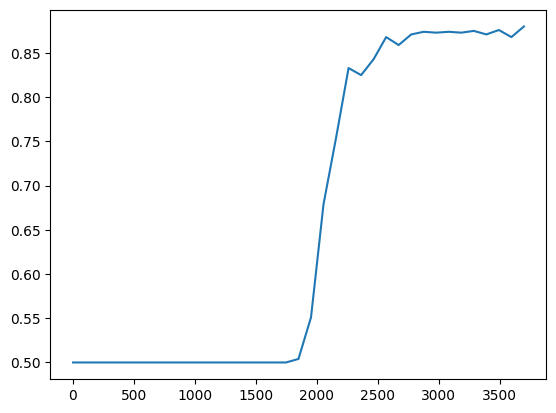

In [ ]:
overall_accuracy = np.array(overall_accuracy)
accuracy_1 = overall_accuracy
print(accuracy_1.shape)
itr_1 = np.linspace(1,3700,37)
plt.plot(itr_1,accuracy_1)

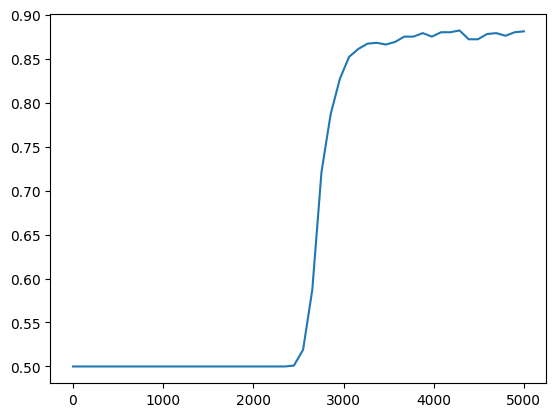

In [ ]:
overall_accuracy = np.array(overall_accuracy)
accuracy_05 = overall_accuracy

itr_05 = np.linspace(1,5000,50)
plt.plot(itr,accuracy_0)
plt.plot(itr_05,accuracy_05)
plt.plot(itr_1,accuracy_1)
plt.legend(['eps_0=0','eps_0=0.5','eps0=1'])

Text(0, 0.5, 'accuracy')

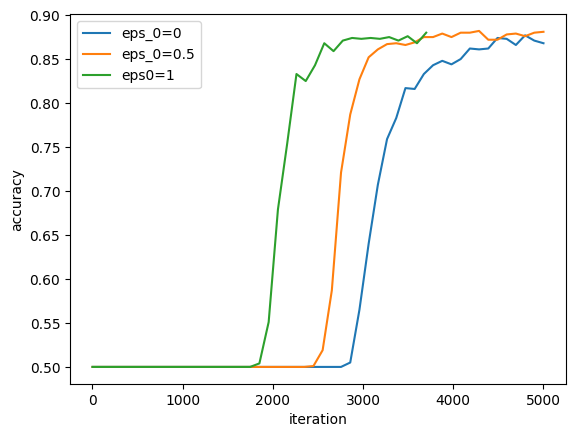

In [ ]:
plt.plot(itr,accuracy_0)
plt.plot(itr_05,accuracy_05)
plt.plot(itr_1,accuracy_1)
plt.legend(['eps_0=0','eps_0=0.5','eps0=1'])
plt.xlabel('iteration')
plt.ylabel('accuracy')